In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import keras, os
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, losses
from keras.layers import Input, Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D, GlobalAveragePooling2D ,AveragePooling2D, Dropout, Activation, BatchNormalization
from keras.models import load_model
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import cv2

# **Read Data**

In [3]:
labels = ['personA', 'personB', 'personC', 'personD', 'personE']

img_size = 224

def get_data(data_dir):
  data = [] 
  for label in labels: 
      path = os.path.join(data_dir, label)
      class_num = labels.index(label)
      for img in os.listdir(path):
          try:
              img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
              resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
              c = [0,0,0,0,0]
              c[class_num] = 1
              data.append([resized_arr, c])
          except Exception as e:
              print(e)
  return np.array(data)

train = get_data('/content/drive/MyDrive/CV_Dataset/Aug_Train')
val = get_data('/content/drive/MyDrive/CV_Dataset/Aug_Validation')

<ipython-input-3-5be82c5a5ea7>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [4]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(991, 224, 224, 3)
(991, 5)
(200, 224, 224, 3)
(200, 5)


# **ResNet-50 _ Model**

In [6]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(5, activation='Softmax')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [9]:
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(restore_best_weights=True, patience=1)

In [10]:
resnet_history = model.fit(x_train, y_train, validation_data = (x_val,y_val), epochs = 10, callbacks = [early_stopping])

Epoch 1/10
31/31 [==============================] - 215s 7s/step - loss: 9.1149 - acc: 0.5600 - val_loss: 0.7736 - val_acc: 0.7850
Epoch 2/10
31/31 [==============================] - 206s 7s/step - loss: 0.3966 - acc: 0.8860 - val_loss: 0.2247 - val_acc: 0.9100
Epoch 3/10
31/31 [==============================] - 207s 7s/step - loss: 0.1776 - acc: 0.9435 - val_loss: 0.1839 - val_acc: 0.9100
Epoch 4/10
31/31 [==============================] - 209s 7s/step - loss: 0.1148 - acc: 0.9677 - val_loss: 0.1256 - val_acc: 0.9750
Epoch 5/10
31/31 [==============================] - 207s 7s/step - loss: 0.0867 - acc: 0.9667 - val_loss: 0.1572 - val_acc: 0.9450


# **Histroy Plot**

In [11]:
def history_plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(len(acc))
  plt.figure(figsize=(12, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

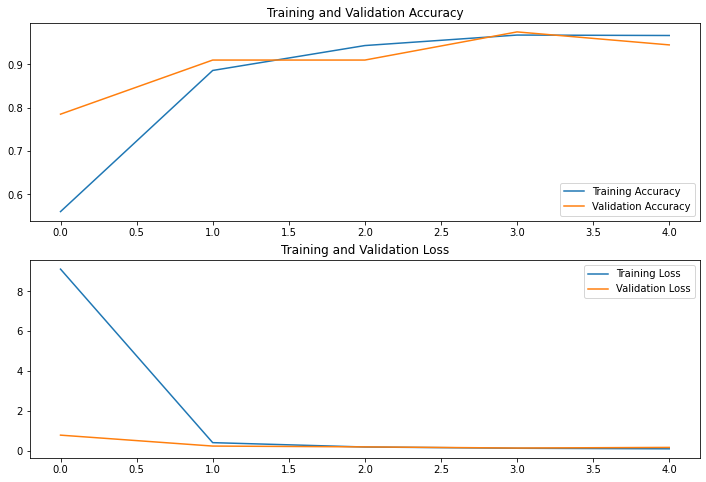

In [12]:
history_plot(resnet_history)

# **Save Model**

In [13]:
from tensorflow.keras.models import load_model
model.save('model_ResNet.h5')

In [14]:
from keras.models import load_model
ResNet_model = load_model('model_ResNet.h5')

In [15]:
def predict_person(path):
  labels = ['personA', 'personB', 'personC', 'personD', 'personE']
  image = load_img(path, target_size=(224, 224))
  img = np.array(image)
  img = img / 255.0
  img = img.reshape(1,224,224,3)
  predictions = ResNet_model.predict(img)
  person = labels[predictions.argmax()]
  return person

image_path = r'/content/drive/MyDrive/CV_Dataset/CV2023TestSamples/SignatureTestSamples/personD_real2.png'
i = predict_person(image_path)
print(i)

1/1 [==============================] - 3s 3s/step
personD
